In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli

from operator import xor

import os


In [2]:
def plot_metric(df, highlight = "Instance", ax=None):
    
    metric = df["Metric"].unique()[0]

    loss_functions = len(df["Loss Function"].unique())
    
    # Create the plot
    ax = ax or plt.gca()

    if loss_functions != 1:
        sns.boxplot(x='Noise Level (%)', y='Rate (%)', hue='Loss Function', data=df, ax=ax, palette="Set2", showfliers=False, boxprops=dict(alpha=0.8))
        sns.stripplot(x="Noise Level (%)", y="Rate (%)", hue="Loss Function", data=df, jitter=True, dodge=True,
                           marker = "x", size=0.5, linewidth=5, ax=ax, alpha = 0.8, palette="Set2", legend = False)
    else:
        sns.boxplot(x='Noise Level (%)', y='Rate (%)', data=df, ax=ax, showfliers=False, boxprops=dict(alpha=0.8))
        sns.stripplot(x="Noise Level (%)", y="Rate (%)", data=df, jitter=True, dodge=True,
                           marker = "x", size=0.5, linewidth=5, ax=ax, alpha = 0.8, legend = False)
    # Scatter plot with or without color

    bright_colors = ['#E63946', '#F4A261', '#2A9D8F', '#264653', '#E9C46A']


    if "disagreement" in metric or "regret" in metric:
        if highlight == "Instance":

            np.random.seed(2024)
            color_indices = np.random.choice(df.Index.unique(), size=5, replace=False)

            for i, item in enumerate(color_indices):
                data_subset = df[df["Index"] == item]

                sns.stripplot(x="Noise Level (%)", y="Rate (%)", hue="Loss Function", data=data_subset, jitter=True, dodge=True,
                              marker='o', facecolors='none', size=10, alpha = 0.8, linewidth=10, edgecolor=bright_colors[i], ax=ax, legend = False)
        elif highlight in ["Class", "age", "sex", "hiv"]:
            unique_vals = df[highlight].unique()
            for i, u in enumerate(unique_vals):
                sns.stripplot(x="Noise Level (%)", y="Rate (%)", hue="Loss Function", data=df[df[highlight]==u], jitter=True, dodge = True,
                                   size=6, alpha = 0.5, palette = bright_colors[i:i+1], ax=ax, legend=False)

        
    # Add legend and adjust plot details
    handles, labels = ax.get_legend_handles_labels()

    # Set plot title and labels if ax is None
    if ax is None:
        ax.set_xlabel('Noise Level (%)')
        ax.set_ylabel(f'{metric} Rate (%)')
        plt.show()

# Note: Ensure the 'metrics' object and the 'metric' variable are properly defined before calling this function.


def load_metrics(model_type, noise_type, uncertainty_type, metric, group = "age",  dataset = 'cshock_eicu', fixed_class = None, fixed_noise = None, epsilon = 0.1):
    
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    
    #metrics_dir = os.path.join(parent_dir, "results", "raw", "metrics", dataset, model_type, noise_type)
    parent_dir = "/scratch/hdd001/home/snagaraj/"
    metrics_dir = os.path.join(parent_dir, "results", "metrics", dataset, model_type, noise_type)

    # Prepare the data
    
    if uncertainty_type == "forward":
        loss_functions = ["BCE", "forward", "backward"]
    else:
        loss_functions = ["BCE"]

    
    if ("disagreement" in metric) or ("regret" in metric):
        
        _, _, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = group)
        
        group_vec = group_test if "test" in metric else group_train
        label_vec = y_test if "test" in metric else y_test
        
        
    rows = []
    
    for loss_function in loss_functions:
        for file_name in os.listdir(metrics_dir):
            if file_name.endswith('.pkl') and uncertainty_type in file_name:
                path = os.path.join(metrics_dir, file_name)

                parts = file_name.split('_')
                noise = float(parts[1]) # Assumes file name format: {uncertainty}_{noise}_{epsilon}_metrics.pkl
                eps = float(parts[2])

                if eps != epsilon:
                    continue
                
                with open(path, 'rb') as file:
                    # The noise level and uncertainty type are inferred from the file name
                    
                    metrics = pkl.load(file)

                for m in metrics.data[loss_function].keys():
                    
                    if m == metric:
                        for i, value in enumerate(metrics.data[loss_function][metric]):
                            if ("disagreement" in metric) or ("regret" in metric):
                                rows.append({
                                    'Metric': m,
                                    'Noise Level (%)': round(noise * 100),  # Assume noise is a fraction
                                    'Rate (%)': value,
                                    'Loss Function': loss_function,
                                    'Index': i,
                                    "Class": label_vec[i],
                                    f"{group}": group_vec[i]})
                
                            else:
                                rows.append({
                                    'Metric': m,
                                    'Noise Level (%)': round(noise * 100),  # Assume noise is a fraction
                                    'Rate (%)': value,
                                    'Loss Function': loss_function,
                                    'Index': i })
                

    # Scan through all files in the directory for the model_type
    
                    
    return pd.DataFrame(rows)



In [3]:
model_type = "NN"
noise_type = "class_independent"

uncertainty_type = "forward"
metric = "disagreement_test"
dataset = "cshock_eicu"
fixed_class = None
fixed_noise = None

metrics_df = load_metrics(model_type, noise_type, uncertainty_type, metric=metric, dataset=dataset, fixed_class=fixed_class, fixed_noise=fixed_noise)

In [4]:
metrics_df

,Metric,Noise Level (%),Rate (%),Loss Function,Index,Class,age
0,disagreement_test,20,100.067668,BCE,0,0,0
1,disagreement_test,20,92.363964,BCE,1,0,0
2,disagreement_test,20,19.019019,BCE,2,1,0
3,disagreement_test,20,88.664264,BCE,3,0,0
4,disagreement_test,20,23.985586,BCE,4,1,0
...,...,...,...,...,...,...,...
4147,disagreement_test,1,0.000000,backward,687,1,0
4148,disagreement_test,1,0.000000,backward,688,1,0
4149,disagreement_test,1,0.000000,backward,689,1,1
4150,disagreement_test,1,1.197598,backward,690,1,0


# Experiment 1 - Noise Robustness / Ambiguity by Model Class

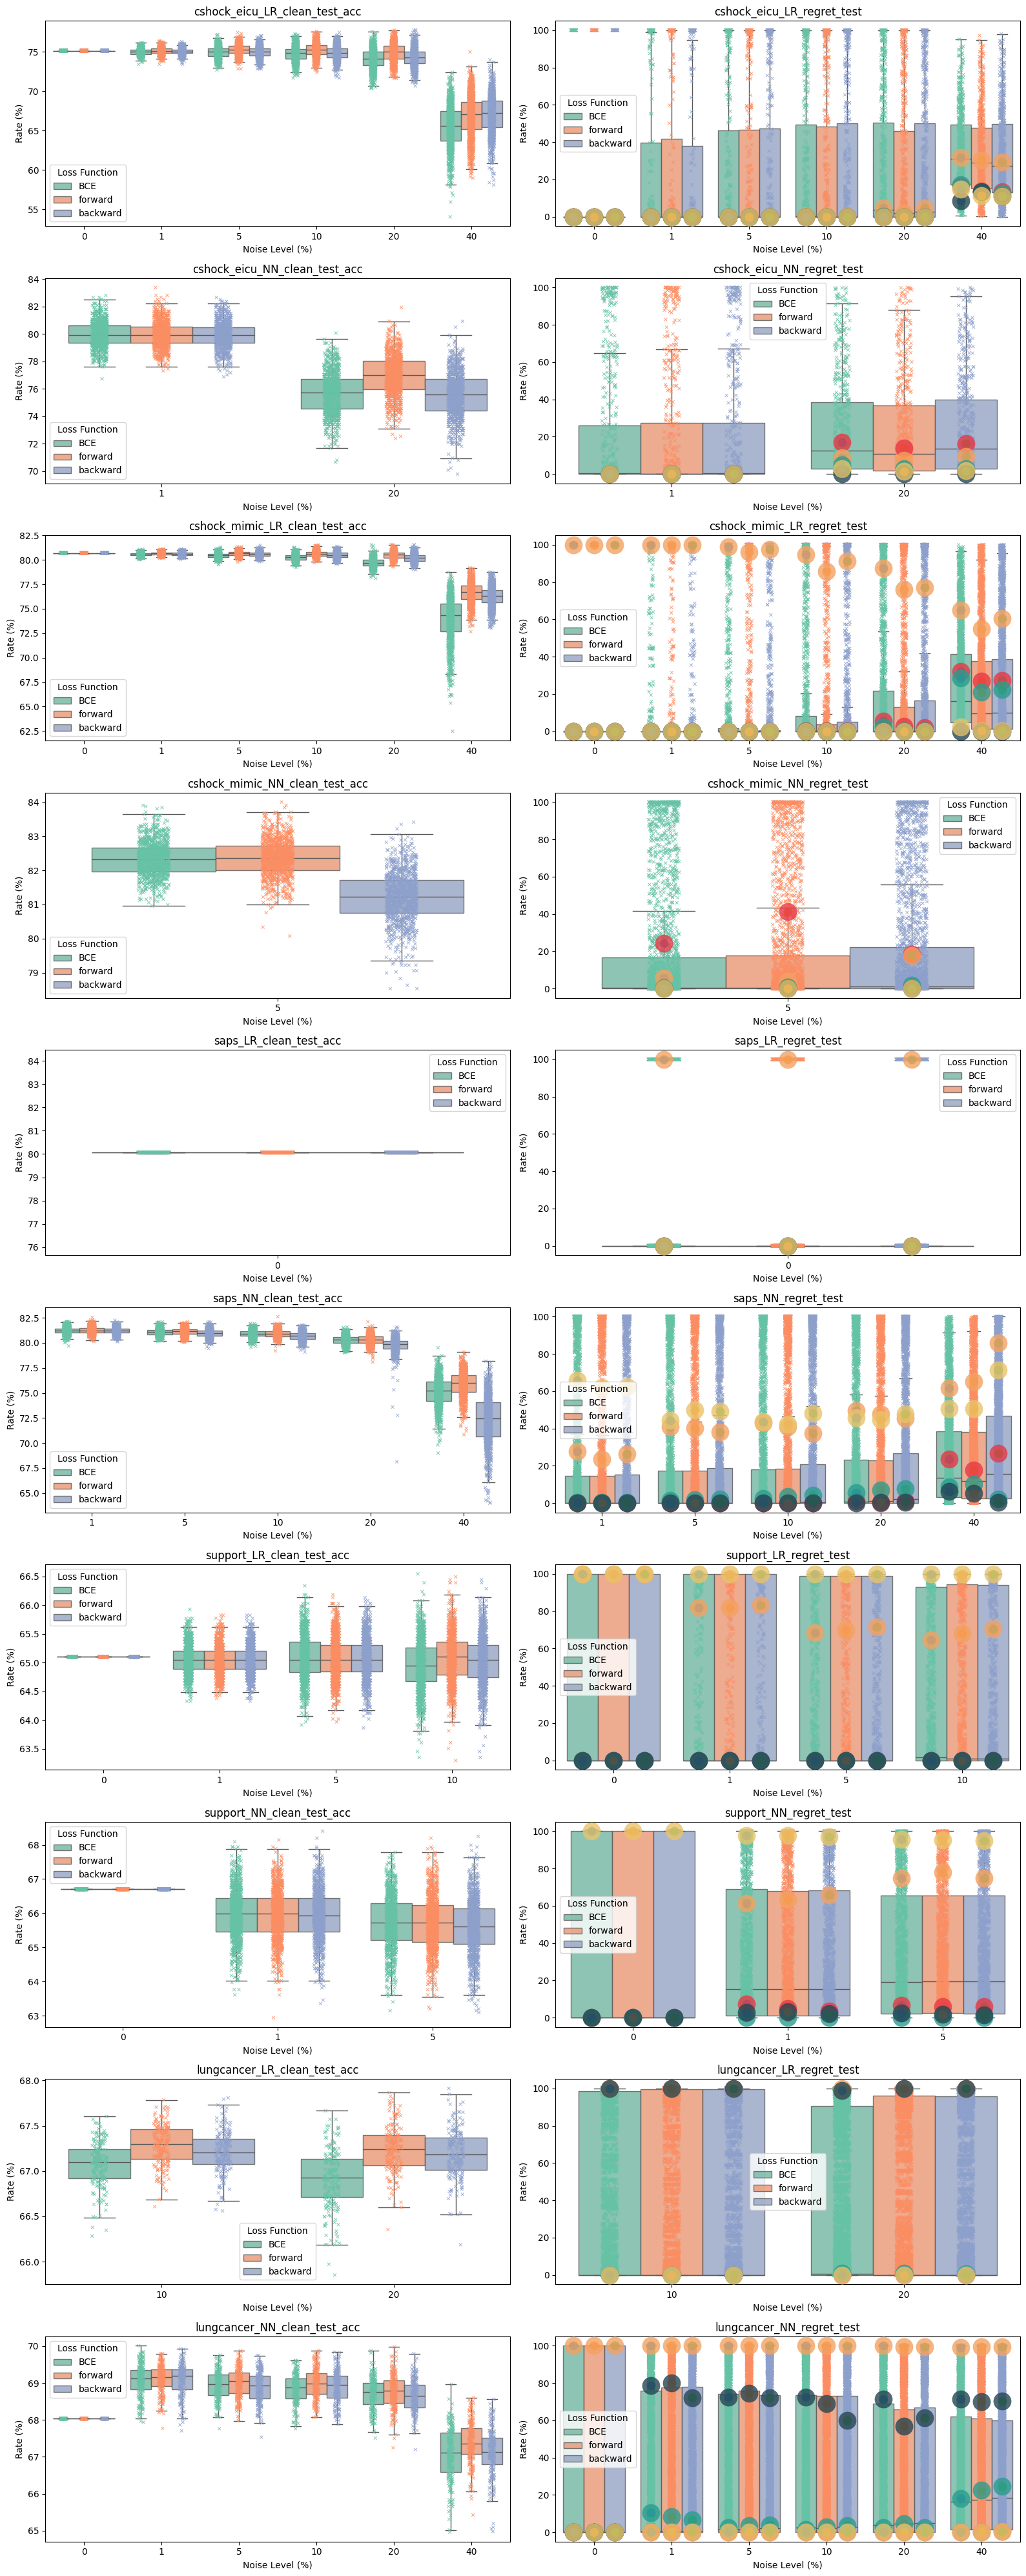

<Figure size 640x480 with 0 Axes>

In [5]:
# Define model types and datasets
model_types = ["LR", "NN"]
datasets = ["cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer"]
metrics = ['clean_test_acc', 'regret_test']

uncertainty_type = "forward"
noise_type = "class_independent"
epsilon = 0.1
fixed_class = 0
fixed_noise = 0

# Create a figure with subplots
# Number of rows is number of datasets times number of model types
# Number of columns is the number of metrics
fig, axs = plt.subplots(len(datasets) * len(model_types), len(metrics), figsize=(16, 4 * len(datasets) * len(model_types)))

# Flatten the axes array for easier indexing
axs = axs.ravel()

# Initialize a counter for the axes
ax_index = 0

# Iterate over datasets and model types
for dataset in datasets:
    for model_type in model_types:
        for metric in metrics:
            try:
                # Load metrics data
                metrics_df = load_metrics(model_type, noise_type, uncertainty_type, metric=metric, dataset=dataset, fixed_class=fixed_class, fixed_noise=fixed_noise, epsilon = epsilon)

                # Plot the metric on the corresponding subplot
                ax = axs[ax_index]
                plot_metric(metrics_df, highlight="Instance", ax=ax)
                ax.set_title(f"{dataset}_{model_type}_{metric}")

                # Increment the axis index for the next metric
                ax_index += 1

            except Exception as e:
                print(f"Failed to load or plot data for {dataset}, {model_type}, {metric}. Error: {str(e)}")
                # Increment the axis index even on failure to keep grid alignment
                ax_index += 1

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

# Optionally, save the figure to a file
plt.savefig("Experiment1.pdf")

# Experiment 2

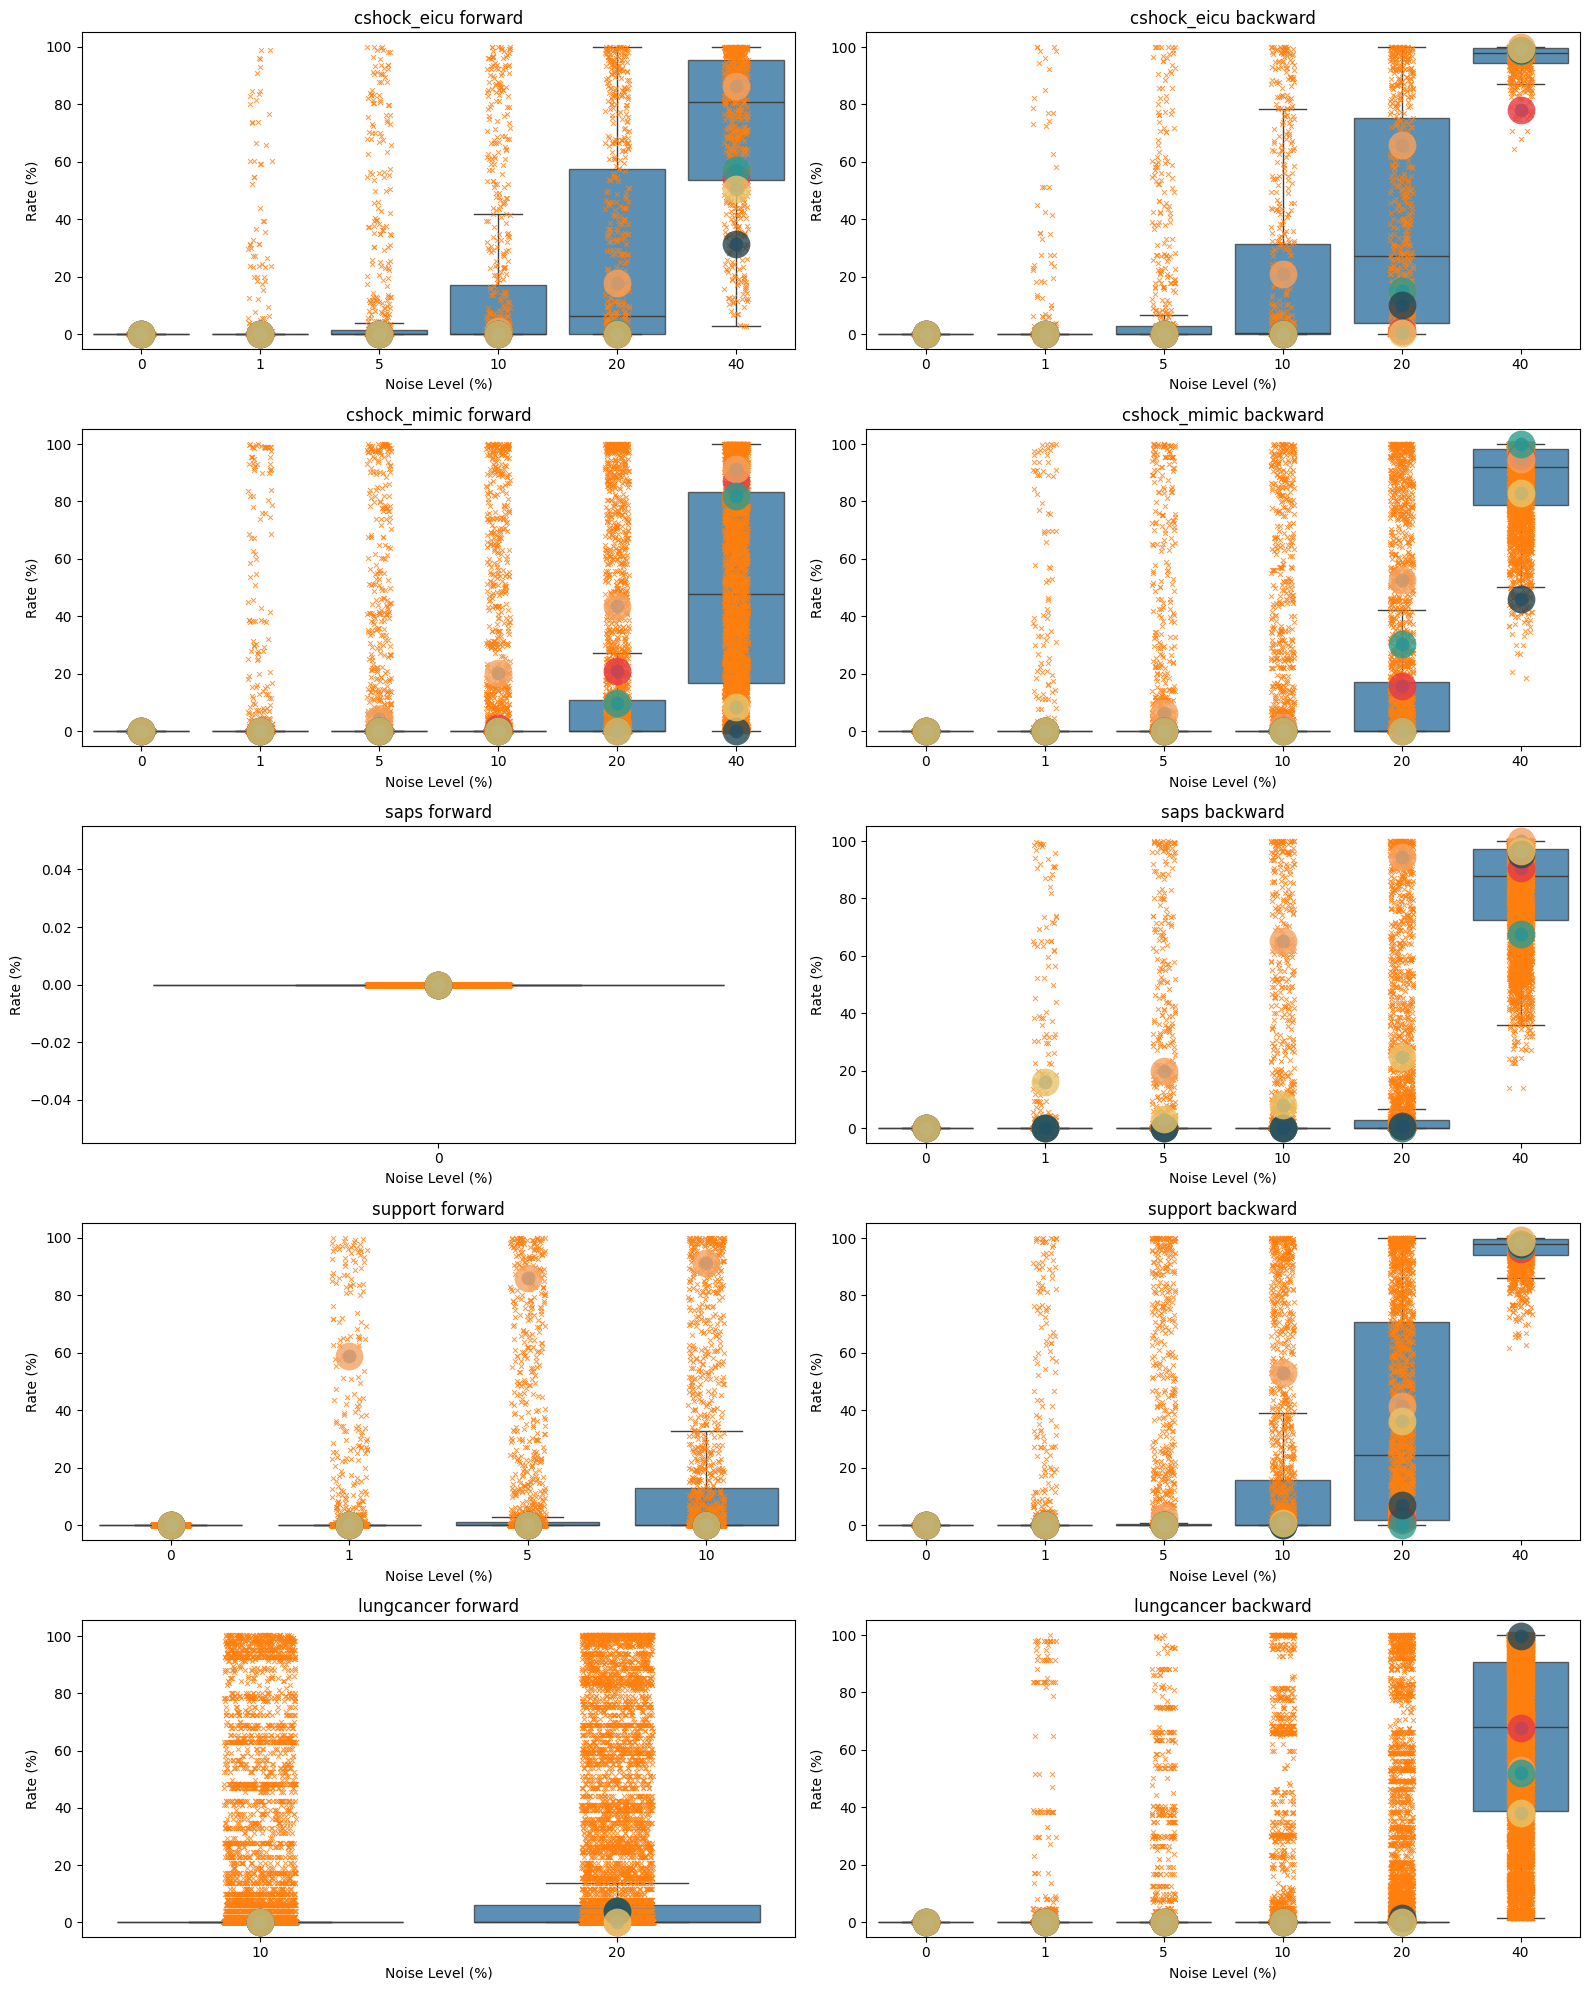

<Figure size 640x480 with 0 Axes>

In [6]:
# Define model types and datasets
model_types = ["LR"]
datasets = ["cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer"]
uncertainty_types = ['forward', 'backward']
metric = "disagreement_test"

# Create a figure with subplots
# Number of rows is number of datasets times number of model types
# Number of columns is the number of metrics
fig, axs = plt.subplots(len(datasets) * len(model_types), len(uncertainty_types), figsize=(16, 4 * len(datasets) * len(model_types)))

# Flatten the axes array for easier indexing
axs = axs.ravel()

# Initialize a counter for the axes
ax_index = 0

# Iterate over datasets and model types
for dataset in datasets:
    for model_type in model_types:
        for uncertainty_type in uncertainty_types:
            try:
                # Load metrics data
                metrics_df = load_metrics(model_type, noise_type, uncertainty_type, metric=metric, dataset=dataset, fixed_class=fixed_class, fixed_noise=fixed_noise)
                
                metrics_df = metrics_df[metrics_df["Loss Function"]=="BCE"]
                # Plot the metric on the corresponding subplot
                ax = axs[ax_index]
                plot_metric(metrics_df, highlight="Instance", ax=ax)
                ax.set_title(f"{dataset} {uncertainty_type}")

                # Increment the axis index for the next metric
                ax_index += 1

            except Exception as e:
                print(f"Failed to load or plot data for {dataset}, {model_type}, {metric}. Error: {str(e)}")
                # Increment the axis index even on failure to keep grid alignment
                ax_index += 1

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

# Optionally, save the figure to a file
plt.savefig("Experiment2a.pdf")

In [7]:
def compute_fpr_tpr(array1, array2, threshold, metric="tpr", fixed_threshold=0.2):
    def indices_above_threshold(array, thresh):
        array = np.where(array > 100, 100, array)
        array = np.where(array < 0, 0, array)
        return ((array > thresh)).astype(int)

    # Get indices above threshold for both arrays
    indices1 = set(indices_above_threshold(array1, fixed_threshold))  # True condition indices
    indices2 = set(indices_above_threshold(array2, threshold))  # Predicted condition indices
    
    # Calculate True Positives (TP) and False Negatives (FN)
    tp = len(indices1 & indices2)  # Intersection of true and predicted positive indices
    fn = len(indices1 - indices2)  # True positives not predicted as positive

    # Calculate False Positives (FP)
    fp = len(indices2 - indices1)  # Predicted positives not actually positive

    if metric == "tpr":
        # True Positive Rate (TPR) calculation
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        return tpr
    elif metric == "fpr":
        # False Positive Rate (FPR) calculation
        # Normally, FPR = FP / (FP + TN), but we assume TN + FP approx. as all negatives,
        # which are all indices not in indices1 (true condition)
        total_negatives = len(array1) - len(indices1)  # Total negatives is approximated as size of array1 minus TP + FN

        fpr = fp / (fp + total_negatives) if (fp + total_negatives) > 0 else 0
        return fpr


In [8]:
array1 = np.array([0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.6, 0.7, 0.7, 0.7])

array2 = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.6, 0.7, 0.7, 0.7])

print(compute_fpr_tpr(array1, array2, 0.05, metric="tpr"))
print(compute_fpr_tpr(array1, array2, 0.05, metric="fpr"))

1.0
0.5


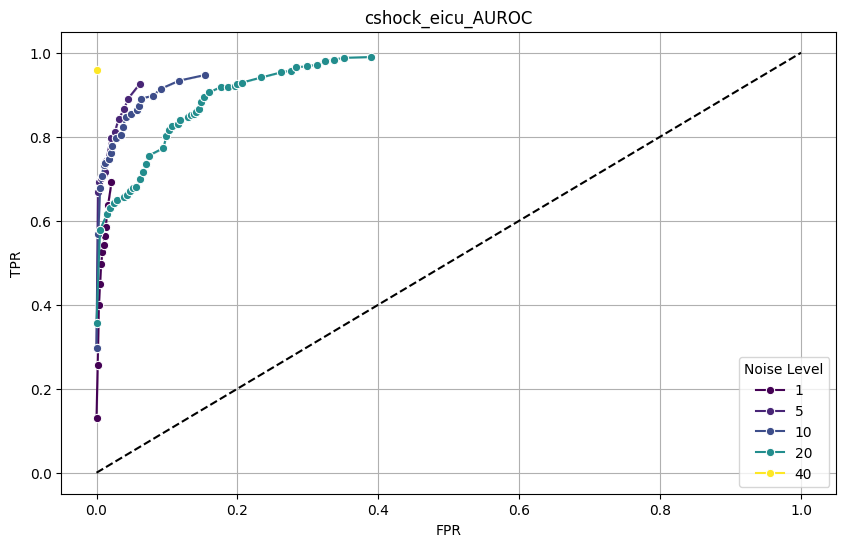

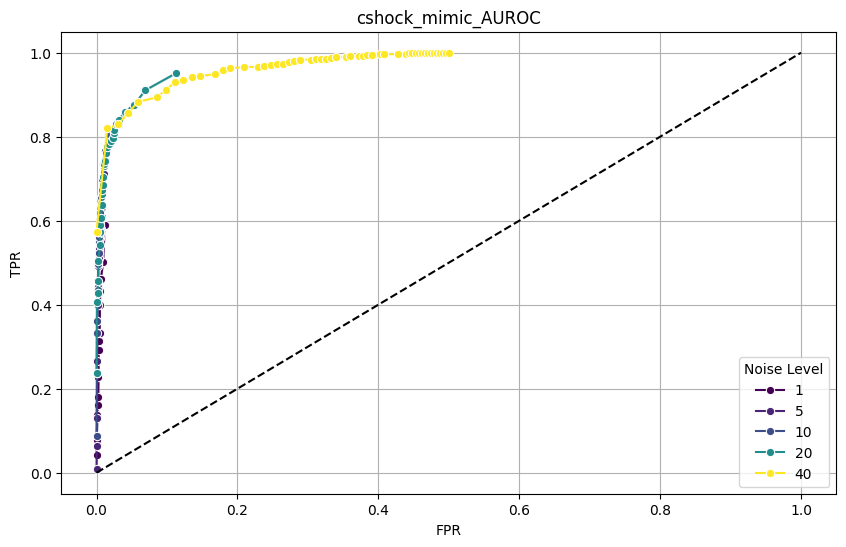

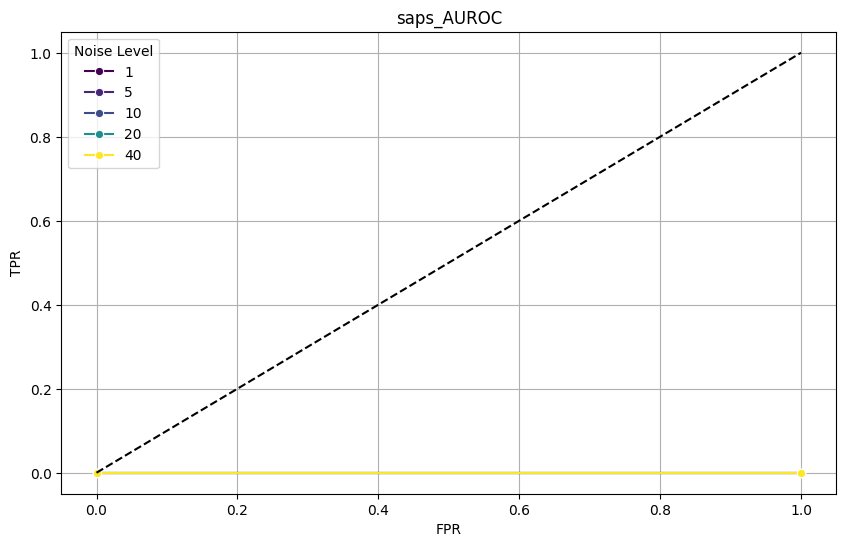

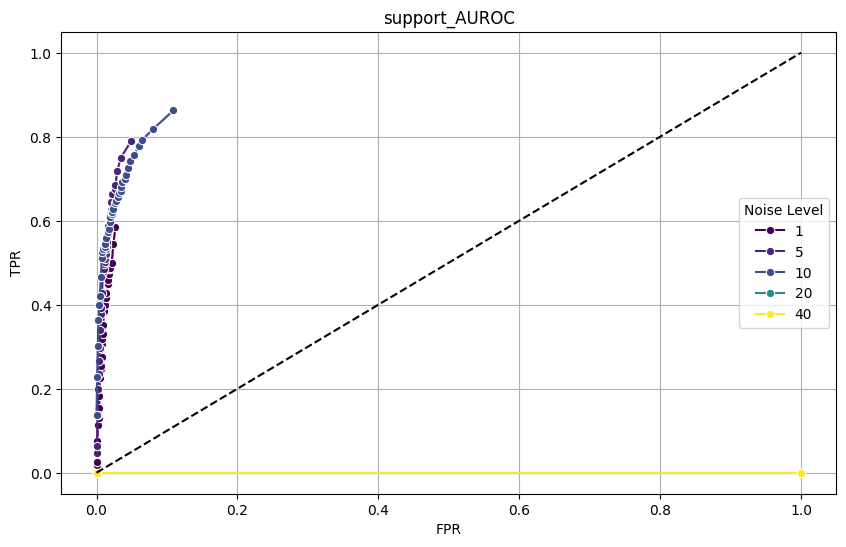

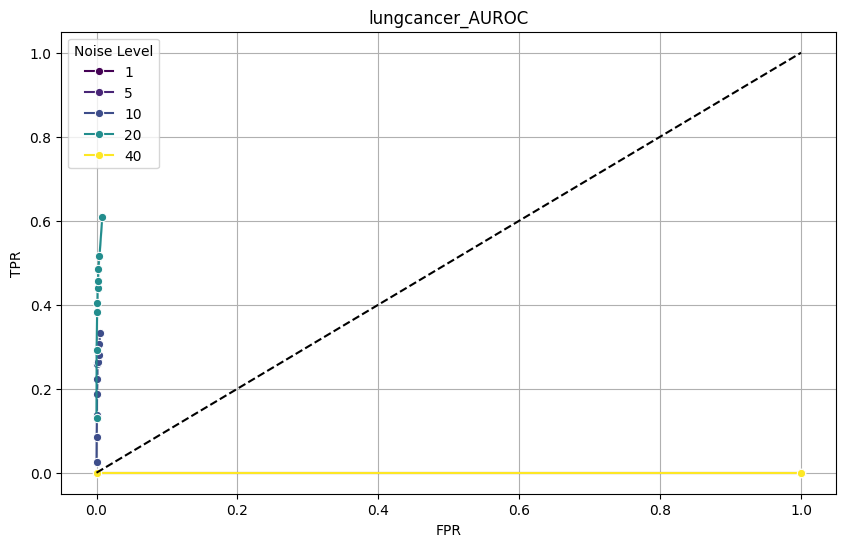

In [10]:
from scipy.stats import spearmanr

# Define the parameters
metric = "disagreement_test"
model_type = "LR"
noise_type = "class_independent"
fixed_class = 0
fixed_noise = 0

fixed_threshold = 0.25


overlap_metric = "dice"
loss = "BCE"

datasets = ["cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer"]

for dataset in datasets:
    # Initialize lists to store the results and noise levels for DataFrame
    thresholds = []  # Generates 20 evenly spaced values from 0 to 100
    overlaps = []
    tprs = []
    fprs = []
    noise_levels = []
    
    forward_df = load_metrics(model_type, noise_type, "forward", metric=metric, dataset = dataset, fixed_class=fixed_class, fixed_noise = fixed_noise)
    backward_df = load_metrics(model_type, noise_type, "backward", metric=metric, dataset = dataset, fixed_class=fixed_class, fixed_noise = fixed_noise)


    for noise_level in [1, 5, 10, 20, 40]:
        forward_sub_df = forward_df[(forward_df["Loss Function"]==loss) & (forward_df["Noise Level (%)"]==noise_level)]
        backward_sub_df = backward_df[(backward_df["Loss Function"]==loss) & (backward_df["Noise Level (%)"]==noise_level)]

        forward_values = forward_sub_df["Rate (%)"].values
        backward_values = backward_sub_df["Rate (%)"].values

                        # Getting rank orderings: argsort gives index positions of sorted order, argsort of that gives ranks
        forward_ranks = np.argsort(np.argsort(forward_values))
        backward_ranks = np.argsort(np.argsort(backward_values))
        
        # Loop over each threshold value
        for threshold in np.linspace(0.0, 100, 100):
            try:
               
                # Calculate Spearman rank correlation
                #result, _ = spearmanr(forward_ranks, backward_ranks)

                overlap = compute_overlap(forward_values, backward_values, threshold, overlap_metric=overlap_metric)
                overlaps.append(overlap)
                noise_levels.append(noise_level)  # Store the corresponding noise level for each result
                thresholds.append(threshold)
                
                tpr = compute_fpr_tpr(forward_values, backward_values, threshold, fixed_threshold = fixed_threshold,  metric="tpr")
                tprs.append(tpr)
                #noise_levels.append(noise_level)  # Store the corresponding noise level for each result
                #thresholds.append(threshold)
                
                fpr = compute_fpr_tpr(forward_values, backward_values, threshold,fixed_threshold= fixed_threshold, metric="fpr")
                fprs.append(fpr)
                #noise_levels.append(noise_level)  # Store the corresponding noise level for each result
                #thresholds.append(threshold)
            except:
                continue
    # Create a DataFrame
    data = pd.DataFrame({
        'Threshold': thresholds,
        'Overlap': overlaps,
        'Noise Level': noise_levels,
        "TPR": tprs,
        "FPR": fprs
    })

    # Plotting using seaborn with hue for noise level
    plt.figure(figsize=(5, 5))
    sns.lineplot(data=data, x='FPR', y='TPR', palette='viridis', hue='Noise Level', marker='o')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel("TPR")
    plt.grid(True)
    plt.title(f'{dataset}_AUROC')
    plt.grid(True)
    plt.show()


# Experiment 3 - typicality of noise draw

In [28]:
def metrics_to_df(metrics_dict, noise_level, seed):
    # Initialize an empty list to hold all the data rows
    data = []
    
    # Loop through each loss function in the dictionary
    for loss_func, metrics in metrics_dict.items():
        # Loop through each metric and its list of values
        for metric, values in metrics.items():
            # Loop through each value in the list
            for idx, value in enumerate(values):
                # Append a new row with the loss function, metric, index, and the value
                data.append({'Loss Function': loss_func, 'Noise Level (%)': int(noise_level*100), 'Metric': metric, 'Index': idx, 'Rate (%)': value, 'Seed': seed})
    
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)
    
    return df


In [29]:
dataset = "support"

X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = "age")

    
noise_type = "class_independent"
noise_level = 20
fixed_class = 1
fixed_noise = 0.0

model_type = "NN"
uncertainty_type = "backward"
batch_size = 512

max_iter = 10000
n_models = 200
d= X_train.shape[1]
noise_level = 0.2


misspecify = False

y_train = y_train.astype(int)
y_test = y_test.astype(int)

p_y_x_dict =  calculate_prior(y_train, noise_type = noise_type, group=group_train) 


In [30]:
_, T_true = generate_class_independent_noise(y_train, noise_level) #Fixed noise draw

T_est = T_true

dfs = []

for seed in [10000, 20000, 30000, 40000, 50000]:
    metrics = simulate_noise_and_train_model(n_models, 
                                             max_iter, 
                                             X_train, 
                                             y_train,
                                             X_test, 
                                             y_test,
                                             p_y_x_dict, 
                                             T_true = T_true,
                                             T_est = T_est,
                                             noise_type = noise_type, 
                                             model_type = model_type, 
                                             uncertainty_type=uncertainty_type,
                                             batch_size = batch_size,
                                             base_seed = seed)
    

    metrics_df = metrics_to_df(metrics.data, noise_level, seed)
    
    metrics_disagreement_df = metrics_df[metrics_df["Metric"] == "disagreement_test"]
    
    dfs.append(metrics_disagreement_df)

  0%|          | 0/10000 [00:00<?, ?it/s]

Typical Rate:  1.0
DONE


  0%|          | 0/10000 [00:00<?, ?it/s]

Typical Rate:  1.0
DONE


  0%|          | 0/10000 [00:00<?, ?it/s]

Typical Rate:  1.0
DONE


  0%|          | 0/10000 [00:00<?, ?it/s]

Typical Rate:  1.0
DONE


  0%|          | 0/10000 [00:00<?, ?it/s]

Typical Rate:  1.0
DONE


In [31]:
stacked_df = pd.concat(dfs)

stacked_df

,Loss Function,Noise Level (%),Metric,Index,Rate (%),Seed
17452,BCE,20,disagreement_test,0,98.241206,10000
17453,BCE,20,disagreement_test,1,9.798995,10000
17454,BCE,20,disagreement_test,2,11.698492,10000
17455,BCE,20,disagreement_test,3,2.0,10000
17456,BCE,20,disagreement_test,4,15.437186,10000
...,...,...,...,...,...,...
19387,BCE,20,disagreement_test,1935,2.0,50000
19388,BCE,20,disagreement_test,1936,52.653266,50000
19389,BCE,20,disagreement_test,1937,2.0,50000
19390,BCE,20,disagreement_test,1938,0.0,50000


In [32]:
def plot_metric_seeds(df, ax=None):
    
    metric = df["Metric"].unique()[0]

    loss_functions = len(df["Loss Function"].unique())
    
    # Create the plot
    ax = ax or plt.gca()


    sns.boxplot(x='Seed', y='Rate (%)', data=df, ax=ax)
    # Scatter plot with or without color

    bright_colors = ['#E63946', '#F4A261', '#2A9D8F', '#264653', '#E9C46A']


    np.random.seed(2024)
    color_indices = np.random.choice(df.Index.unique(), size=5, replace=False)

    for i, item in enumerate(color_indices):
        data_subset = df[df["Index"] == item]

        sns.stripplot(x="Seed", y="Rate (%)", hue="Loss Function", data=data_subset, jitter=True, dodge=True,
                      marker='o', facecolors='none', size=10, alpha = 0.8, linewidth=10, edgecolor=bright_colors[i], ax=ax, legend = False)

    # Add legend and adjust plot details
    handles, labels = ax.get_legend_handles_labels()

    # Set plot title and labels if ax is None
    if ax is None:
        ax.set_xlabel('Seed')
        ax.set_ylabel(f'{metric} Rate (%)')
        plt.show()

# Note: Ensure the 'metrics' object and the 'metric' variable are properly defined before calling this function.



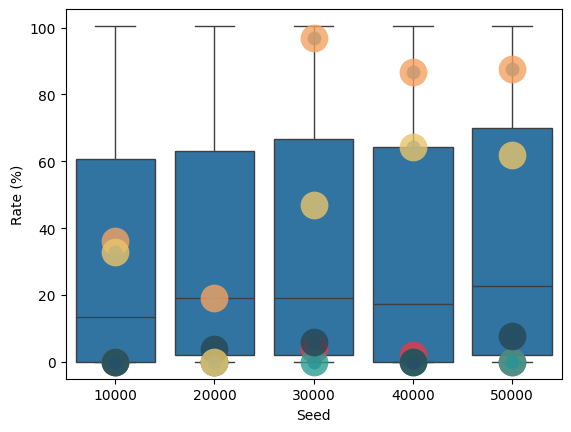

In [33]:
plot_metric_seeds(stacked_df)

# Experiment 4 - Noise model vs ambiguity

/tmp/ipykernel_29922/3359102615.py:37: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(x="Noise Level (%)", y="Rate (%)", hue="Loss Function", data=df[df[highlight]==u], jitter=True, dodge = True,
/tmp/ipykernel_29922/3359102615.py:37: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(x="Noise Level (%)", y="Rate (%)", hue="Loss Function", data=df[df[highlight]==u], jitter=True, dodge = True,


Failed to load or plot data for cshock_eicu, LR, disagreement_test. Error: 'Metric'


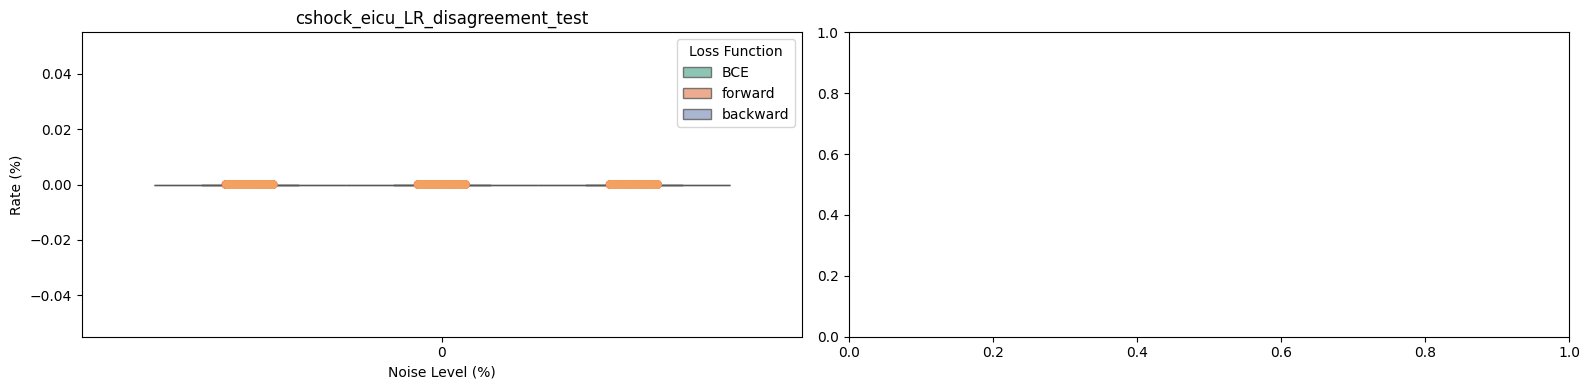

<Figure size 640x480 with 0 Axes>

In [34]:
# Define model types and datasets
model_types = ["LR"]
datasets = ["cshock_eicu"]
metric = "disagreement_test"

noise_types = [ "class_independent", "class_conditional"]

uncertainty_type = "forward"
fixed_class = 0
fixed_noise = 0.0

# Create a figure with subplots
# Number of rows is number of datasets times number of model types
# Number of columns is the number of metrics
fig, axs = plt.subplots(len(datasets) * len(model_types), len(noise_types), figsize=(16, 4 * len(datasets) * len(model_types)))

# Flatten the axes array for easier indexing
axs = axs.ravel()

# Initialize a counter for the axes
ax_index = 0

# Iterate over datasets and model types
for dataset in datasets:
    for model_type in model_types:
        for noise_type in noise_types:
            try:
                # Load metrics data
                metrics_df = load_metrics(model_type, noise_type, uncertainty_type, metric=metric, dataset=dataset, fixed_class=fixed_class, fixed_noise=fixed_noise)

                # Plot the metric on the corresponding subplot
                ax = axs[ax_index]
                plot_metric(metrics_df, highlight="Class", ax=ax)
                ax.set_title(f"{dataset}_{model_type}_{metric}")

                # Increment the axis index for the next metric
                ax_index += 1

            except Exception as e:
                print(f"Failed to load or plot data for {dataset}, {model_type}, {metric}. Error: {str(e)}")
                # Increment the axis index even on failure to keep grid alignment
                ax_index += 1

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

# Optionally, save the figure to a file
plt.savefig("Experiment4.pdf")

# 